In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Wczytanie danych

In [3]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

## Przygotwanie zmiennych

Najpierw konwertujemy odpowiedź `S1` na zmienną binarną, gdzie 1 odpowiada informacji `Yes, I am Married`

In [4]:
df['y'] = 1 - df['S1'].cat.codes
y = df['y']

### Wybrane zmienne

Do modelu wybrałem następujące zmienne  
1) kategoryczne:  
  a) `Q23` - Between you and [Partner name], who earned more income in 2016,  
  b) `Q28` - Did your parents know [Partner name]’s parents before you met [Partner name]?,  
2) uporządkowane:  
  a) `ppp20072` - Q27: How often do you attend religious services?,  
  b) `w6_how_many` - How many Different people besides [Partner name] have you met for dating, or rom   

Wszystkie zmienne są zakodowane przez kategorię, które odkoduję.

In [39]:
X = df[['Q23', 'Q28', 'ppp20072', 'w6_how_many']].apply(lambda x: x.cat.codes, axis=0)

In [40]:
X.apply(lambda x: x==-1).mean()

Q23            0.186325
Q28            0.186325
ppp20072       0.033048
w6_how_many    0.935897
dtype: float64

Pandas wszystkie Nany koduje jako kategorię -1, jednak ze względu na ich duży udział w zbiorze, zwłaszcza w zmiennej `w6_how_many` wyrzucę je ze zbioru danych.

In [41]:
y = df.loc[X.min(axis=1) >= 0, 'y']

In [42]:
X = X.loc[X.min(axis=1) >= 0]

In [43]:
X.shape

(225, 4)

Zostało nam 225 obserwacji co oznacza, że nie ma sensu uczyć modelu o dużej pojemności. Z tego powodu wybrałem las losowy o 25 drzewach i maksymalnej głębokości 3.

Stworzymy dodatkowo słowniki do zmiennych kategorycznych by łatwiej odwikłać potem kategorię.

In [86]:
d_ppp20072 = dict(enumerate(df['ppp20072'].cat.categories))
d_w6_how_many = dict(enumerate([cat.split(".")[0] for cat in df['w6_how_many'].cat.categories]))

In [88]:
d = {
    'ppp20072': d_ppp20072,
    'w6_how_many': d_w6_how_many
}

## Budowa modelu

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
rf = RandomForestClassifier(n_estimators=25, max_depth=4)

In [91]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Ceterus Paribus

Ponieważ korzystam tylko z zmiennych uporządkowanych funkcja `ceterus_paribus` będzie poprostu przyjmowała wszystkie wartości możliwe dla danej zmiennej.

In [92]:
def ceterus_paribus(df, obs, model, variable):
    unique_values = sorted(list(df[variable].unique()))
    preds = []
    for value in unique_values:
        X_temp = df.iloc[obs, :]
        X_temp[variable] = value
        preds.append(rf.predict_proba(X_temp.values.reshape(1,-1))[0, 1])
    unique_values = list(map(lambda x: d[variable][x], unique_values))
    plt.plot(unique_values, preds)
    #return preds, unique_values

Będziemy analizować obserwację 150 czyli:

In [112]:
df.dropna(subset=X.columns).iloc[150].loc[X.columns]

Q23                                                I earned more
Q28                                                           No
ppp20072                                                   Never
w6_how_many    One person. I met only one person besides [Par...
Name: 2512, dtype: object

Osobę ktora:  
1) zarabiała więcej od partnera,   
2) jej rodzice nie znali rodziców partnera przed poznaniem,  
3) Nigdy nie bierze udziału w obrzędach religijnych,  
4) Przed spotkaniem swojego partnera spoktykała się tylko z 1 inną osobą.

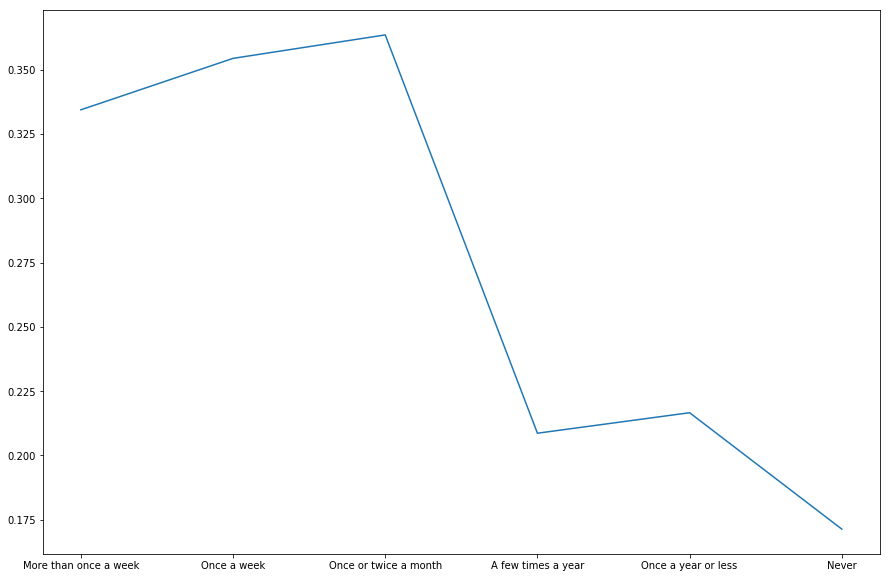

In [107]:
plt.figure(figsize=(15,10))
ceterus_paribus(X, 150, rf, "ppp20072")

Widać że w powyższym przypadku obserwacji numer 150, największe p-stwo że osoba jest zameżna jest przy uczęszczaniu w obrzędach religijnych raz w tygodniu. Dla osób, które robią to rzadziej to p-stwo znacząco spada.

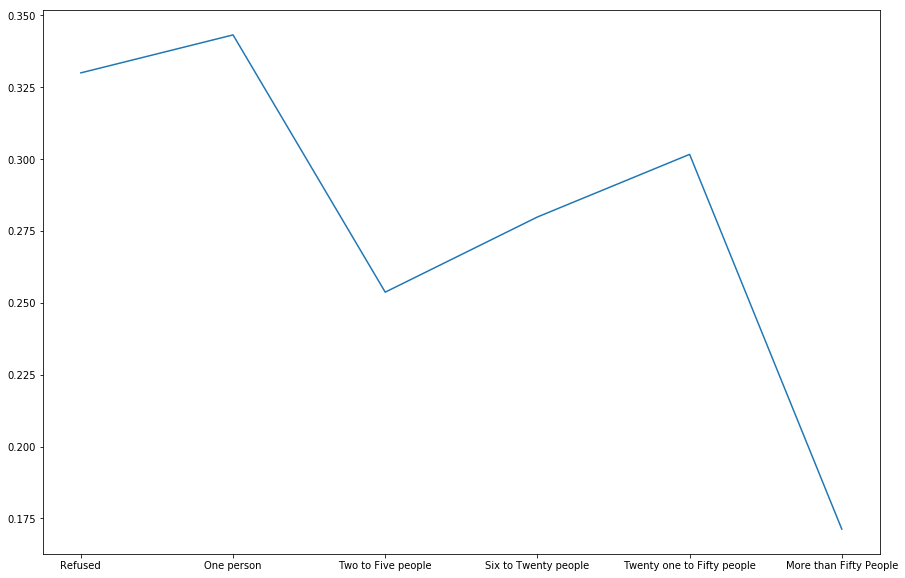

In [108]:
plt.figure(figsize=(15,10))
ceterus_paribus(X, 150, rf, "w6_how_many")

W przypadku zmiennej mówiącej z iloma partnerami wcześniej dana osoba się spotykała dla obserwacji 150 widać relację, gdzie z im więcej osobami dana osoba się spotykała tym ma mniejsze p-stwo bycia osobą zamężną.